# YouTube Comments and Video Stats Analysis

## I. Import Libraries

In [1]:
import re
import string
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
from textblob import TextBlob

# Natural Language Toolkit
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Language Detector
try:
    import langid
except ModuleNotFoundError:
    !pip install langid
    import langid

try:
    from langdetect import detect, LangDetectException
except ModuleNotFoundError:
    !pip install langdetect
    from langdetect import detect, LangDetectException

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 83.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=9cb8c8d718f76dbcd39f37f11f41db836b8c53349f6e50f937bb2aa57a88ed2a
  Stored in directory: /home/repl/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 58.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=e8b662ce4635e1a2287663ebc4484170ed770caa4f332d595edc9297e37e2db8
  Stored in directory: /home/repl/.ca

### Download NLTK data files 

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/repl/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/repl/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/repl/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/repl/nltk_data...


True

### Notebook Preferences

- Setup visualization aesthetics
- Supress warnings

In [3]:
# Setup visualization
sns.set(style="whitegrid")

# Supress warnings
warnings.filterwarnings('ignore')

## II. Load the Datasets

- Save the datasets in variables

In [4]:
# CSV format
comments_csv_url = 'https://raw.githubusercontent.com/cogxen/databank/main/youtube-comments-video-stats/comments.csv'
video_stats_csv_url = 'https://raw.githubusercontent.com/cogxen/databank/main/youtube-comments-video-stats/video-stats.csv'

# XLSX format
comments_xlsx_url = 'https://raw.githubusercontent.com/cogxen/databank/main/youtube-comments-video-stats/comments-eng.xlsx'
video_stats_xlsx_url = 'https://raw.githubusercontent.com/cogxen/databank/main/youtube-comments-video-stats/video-stats-eng.xlsx'

### (`.csv`) Comments & Video Stats DataFrame 

- Comments Data

In [5]:
comments_csv = pd.read_csv(comments_csv_url)
comments_csv.head()

,Video ID,Comment,Likes,Sentiment
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2


- Video Stats Data

In [6]:
video_stats_csv = pd.read_csv(video_stats_csv_url)
video_stats_csv.head()

,Title,Video ID,Published At,Keyword,Likes,Comments,Views
0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,23/08/2022,tech,3407.0,672.0,135612.0
1,The most EXPENSIVE thing I own.,b3x28s61q3c,24/08/2022,tech,76779.0,4306.0,1758063.0
2,My New House Gaming Setup is SICK!,4mgePWWCAmA,23/08/2022,tech,63825.0,3338.0,1564007.0
3,Petrol Vs Liquid Nitrogen | Freezing Experimen...,kXiYSI7H2b0,23/08/2022,tech,71566.0,1426.0,922918.0
4,Best Back to School Tech 2022!,ErMwWXQxHp0,08/08/2022,tech,96513.0,5155.0,1855644.0


### (`.xlsx`) Comments & Video Stats

- Comments Data

In [7]:
comments_xlsx = pd.read_excel(comments_xlsx_url)
comments_xlsx.head()

,Video ID,Comment,Likes,Sentiment
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2


- Video Stats Data

In [8]:
video_stats_xlsx = pd.read_excel(video_stats_xlsx_url)
video_stats_xlsx.head()

,Title,Video ID,Published At,Keyword,Likes,Comments,Views
0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,2022-08-23,tech,3407,672,135612
1,The most EXPENSIVE thing I own.,b3x28s61q3c,2022-08-24,tech,76779,4306,1758063
2,My New House Gaming Setup is SICK!,4mgePWWCAmA,2022-08-23,tech,63825,3338,1564007
3,Best Back to School Tech 2022!,ErMwWXQxHp0,2022-08-08,tech,96513,5155,1855644
4,Brewmaster Answers Beer Questions From Twitter...,18fwz9Itbvo,2021-11-05,tech,33570,1643,943119


- Define file paths and options
- Load the datasets
    - Rename the columns
- Check data integrity  

In [9]:
# Defile file paths and options based on the source
data_source = 'eff'

if data_source == 'org':
    print('Loading original source...')
    comments_file = comments_csv_url
    video_stats_file = video_stats_csv_url
    load_function = pd.read_csv
    load_options = {'parse_dates': ['Published At'], 'dayfirst': True}
    comments_columns_mapping = []
else:
    print('Loading efficient source...')
    comments_file = comments_xlsx_url
    video_stats_file = video_stats_xlsx_url
    load_function = pd.read_excel
    load_options = {}
    comments_columns_mapping = ['Video ID', 'Comment', 'Comment_Likes', 'Comment_Sentiment']
    
# Load the datasets
video_stats = load_function(video_stats_file, **load_options)
comments = load_function(comments_file, **load_options)

# Rename columns
if data_source != 'org':
    comments.columns = comments_columns_mapping
    
# Definitions
metrics = ['Views', 'Likes', 'Comments']

# Checks data integrity
initial_shape = video_stats.shape
print(f'Initial shape of video stats: {initial_shape}')
duplicate_count = initial_shape[0] - video_stats[['Title', 'Published At', 'Keyword', 'Likes', 'Comments', 'Views']].drop_duplicates().shape[0]
print(f'Number of duplicate rows: {duplicate_count}')

Loading efficient source...
Initial shape of video stats: (1577, 7)
Number of duplicate rows: 0


## III. Helper Functions

### (`preprocess_text`) 

**Text Preprocessing Method**, it involves transforming raw text data into a structured format suitable for analysis by converting text to lowercase, removing punctuation and stop words, tokenizing, and lemmatizing, ultimately rejoining the tokens into a single string. This process is crucial for enabling effective natural language processing tasks.

In [10]:
def preprocess_text(raw_text):
    # Ensure the input is a string
    if not isinstance(raw_text, str):
        raw_text = str(raw_text)
    
    # Convert text to lowercase
    text_lower = raw_text.lower()
    
    # Remove punctuation
    text_no_punct = text_lower.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the text
    word_tokens = word_tokenize(text_no_punct)
    
    # Remove stopwords and punctuation tokens
    stopwords_set = set(stopwords.words('english'))
    filtered_tokens = [word for word in word_tokens if word not in stopwords_set and word not in string.punctuation]
    
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    # Rejoin the tokens into a single string
    preprocessed_text = ' '.join(lemmatized_tokens)
    
    return preprocessed_text

### (`determine_language`) 

**Language Determination Method**, it employs a hybrid approach, leveraging both `langdetect` and `langid` libraries to identify the dominant language within a given text. It returns 'en' if either library confidently detects English; otherwise, it classifies the language as 'unknown'. This strategy is particularly valuable for applications that handle multilingual content and necessitate a robust language identification mechanism with a fallback option.

In [11]:
# Function to determine the language of a given text using langdetect
def determine_language_langdetect(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Function to determine the language of a given text using langid
def determine_language_langid(text):
    language, _ = langid.classify(text)
    return language

# Combined function to determine the language using both methods
def determine_language(text):
    lang_langdetect = determine_language_langdetect(text)
    lang_langid = determine_language_langid(text)
    
    if lang_langdetect == 'en' or lang_langid == 'en':
        return 'en'
    else:
        return 'unknown'

### (`classify_sentiment`) 

**Sentiment Classification Method**, it maps polarity scores to their respective sentiment categories ('Negative', 'Neutral', or 'Positive'), providing a valuable tool for applications requiring text categorization based on sentiment analysis.

In [12]:
def classift_sentiment(polarity_score):
    if polarity_score < -0.2:
        return 'Negative'
    elif polarity_score < 0.2:
        return 'Neutral'
    else:
        return 'Positive'

### (`analyze_sentiment`) 

**Sentiment Analysis Method**, it analyzes the sentiment of the input text using the TextBlob library and returns the polarity score, which is useful for understanding the emotional tone of the text.

In [13]:
def analyze_sentiment(input_text):
    if not isinstance(input_text, str):
        input_text = str(input_text)
    
    tb = TextBlob(input_text)
    return tb.sentiment.polarity

### (`calculate_text_length`)

**Text Length Calculation Method**, it calculates the length of the input text, converting it to a string if necessary.

In [14]:
def calculate_text_length(input_text):
    if not isinstance(input_text, str):
        input_text = str(input_text)
    return len(input_text)

### (`is_text_string`) 

**Text Type Check Method**, it checks if the input is a string and returns a boolean value indicating the result.

In [15]:
def is_text_string(input_text):
    return isinstance(input_text, str)

### (`compute_engagement_rate`)

**Engagement Rate Computation Method**

It computes the engagement rate based on the number of likes, comments, and views, with optional weights for likes and comments. This method is useful for social media analytics and content performance evaluation.

**Paramaters**
1. `likes` (`int`): The number of likes.
2. `comments` (`int`): The number of comments.
3. `views` (`int`): The number of views.
4. `like_weight` (`float`, `optional`): The weight assigned to likes. Default is 1.
5. `comment_weight` (`float`, `optional`): The weight assigned to comments. Default is 1.5.

**Returns**
- `float`: The engagement rate as a percentage.

In [16]:
def compute_engagement_rate(likes, comments, views, like_weight=1, comment_weight=1.5):
    if views == 0:
        return 0
    return ((like_weight * likes + comment_weight * comments) / views) * 100

### (`generate_sort_order`) 

**Sort Order Generation Method**, it generates a sort order based on the median of a specified metric for groups in the dataframe, which is useful for ranking groups by their performance on various metrics.

**Parameters**
1. `dataframe` (`pd.DataFrame`): The dataframe containing the data.
2. `group_column` (`str`): The column to group by.

**Returns**
- `list`: A list of group names sorted by their median engagement rate in descending order.

In [17]:
def generate_sort_order(dataframe, group_column, metric_column):
    group_medians = dataframe.groupby(group_column)[metric_column].median().sort_values(ascending=False)
    sort_order = group_medians.index.tolist()
    return sort_order

### (`plot_median_metric_by_group`)

**Median Metric by Group Plotting Method**, it plots the median of a specified metric by group, which is useful for visualizing the performance of groups on various metrics.

**Parameters**
1. `dataframe` (`pd.DataFrame`): The dataframe containing the data.
2. `group_column` (`str`): The column to group by.
3. `metric_column` (`str`, `optional`): The column representing the metric to plot.

In [18]:
def plot_median_metric_by_group(dataframe, group_column, metric_column):
    # Calculaate the median of the specified metric by group and sort by value
    grouped_medians = dataframe.groupby(group_column)[metric_column].median().sort_values(ascending=False).reset_index()
    
    # Melt the dataframe for plotting    
    melted_data = grouped_medians.melt(id_vars=[group_column])
    melted_data.columns = [group_column, 'Metric', 'Value']
    
    # Filter for the specified metric and sort by value
    filtered_data = melted_data[melted_data['Metric'] == metric_column].sort_values(by='Value', ascending=False)
    
    # Plot the data
    sns.barplot(data=filtered_data, y=group_column, x='Value')

### (`remove_outliers_by_category`) 

**Outlier Removal by Category Method**, it removes outliers from the DataFrame based on the category of the item using the Interquartile Range (IQR) method, which is useful for cleaning data before analysis.

**Parameters**
1. `dataframe` (`pd.DataFrame`): The input DataFrame.
2. `category_column` (`str`): The name of the category column.
3. `value_column` (`str`): The name of the value column.

**Returns**
- `pd.DataFrame`: The DataFrame with outliers removed.

In [19]:
def remove_outliers_by_category(dataframe, category_column, value_column):
    def filter_outliers(group):
        q1 = group[value_column].quantile(0.25)
        q3 = group[value_column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return group[group[value_column].between(lower_bound, upper_bound)]
    
    return data.groupby(category_col).apply(filter_outliers).reset_index(drop=True)

### (`filter_non_alphanumeric_tokens`)

**Token Filtering Method**, it filters out tokens that are purely numeric or single characters, which is useful for cleaning tokenized text data.

In [20]:
def filter_non_alphanumeric_tokens(tokens):
    return [str(token) for token in tokens if not re.match(r'^\d+$|^.{1}$', str(token))]            

### (`get_most_common_tokens_by_category`), 

**Most Common Tokens by Category Extraction Method**, it extracts the most common tokens for each category in the dataframe, which is useful for analyzing the most frequent terms in different categories.

**Parameters** (`get_most_common_tokens_by_category`)
1. `dataframe` (`pd.DataFrame`): The input dataframe.
2. `category_column` (`str`): The name of the column containing category information.
3. `tokens_column` (`str`): The name of the column containing tokens.
4. `top_n` (`int`, `optional`): The number of most common tokens to return. Default is 3.

**Returns**
- `dict`: A dictionary where keys are categories and values are lists of the most common tokens.

In [21]:
def get_most_common_tokens_by_category(dataframe, category_column, tokens_column, top_n=3):
    # Group the dataframe by the specified category column
    grouped = dataframe.groupby(category_column)
    
    # Initialize a dictionary to store the most common tokens for each category
    common_tokens = {}
    
    # Iterate through each group (category)
    for category, group in grouped:
        all_tokens = []
        # Collect all tokens from the specified tokens column, filtering out non-alphanumeric tokens
        for tokens in group[tokens_column]:
            filtered_tokens = filter_non_alphanumeric_tokens(tokens)
            all_tokens.extend(filtered_tokens)
            
        # Count the frequency of each token
        token_counts = Counter(all_tokens)
        
        # Retrieve the top_n most common tokens for the current category
        common_tokens[category] = token_counts.most_common(top_n)
        
    return common_tokens

### (`find_keywords`)

**Keyword Extraction Method**, it extracts keywords from a given text that are present in a provided list of keywords, which is useful for categorizing or tagging text based on their content. 

**Parameters**
1. `text` (`str`): The text to search for keywords.
2. `keyword_list` (`list`): A list of keywords to search for in the text.

**Returns**
- `list`: A list of found keywords or ['other'] if no keywords are found.

In [22]:
def find_keywords(text, keyword_list):
    found_keywords = [keyword for keyword in keyword_lit in keyword in text]
    return found_keywords if found_keywords else ['other']

### (`update_industry_based_on_artists`)

**Industry Update Based on Artists Method**, it updates the industry column to 'Music' if any artist from the list is found in the cleaned title.

**Parameters**
1. `row` (`pd.Series`): A row of the DataFrame.
2. `artists` (`list`): A list of artist names.
3.  `title_column` (`str`): The name of the column containing the cleaned title.

**Returns**
- `str`: The updated industry value.

In [23]:
def update_industry_based_on_artists(row, artists, column):
    for artist in artists:
        if artist in row[column]:
            return 'Music'
    return row['Industry']

### (`update_keyword_based_on_artists`)

**Keyword Update Based on Artists Method**, it updates the keyword column to 'music' if any artist from the list is found in the specified title column.

**Parameters**
1. `row` (`pd.Series`): A row of the DataFrame.
2. `artists` (`list`): A list of artist names.
3. `title_column` (`str`): The name of the column containing the cleaned title.

**Returns**
- `str`: The updaated keyword value.

In [24]:
def update_keyword_based_on_artists(row, artists, column):
    for artist in artists:
        if artist in row[column]:
            return 'music'
    return row['Keyword']

### (`plot_engagement_rate_by_column`)

**Engagement Rate Distribution Analysis by Category**, it specifically visualizes the distribution of engagement rates across different categories.

**Parameters**
1. `dataframe` (`pd.DataFrame`): The dataset.
2. `column_name` (`str`): The column to group by.
3. `target_metric` (`str`): The metric to plot (e.g., 'Engagement Rate').

In [66]:
def plot_engagement_rate_by_column(dataframe, column_name, target_metric):
    sort_order = generate_sort_order(dataframe, column_name, target_metric)
    sns.boxplot(data=dataframe, y=column_name, x=target_metric, order=sort_order)
    plt.title(f"{target_metric} by {column_name}")
    plt.tight_layout()
    plt.show()

### (`plot_capped_views_by_column`)

**Capped Views Distribution Analysis by Category Method**, it specifically visualizes the distribution of capped views across different categories using boxplots, with a specified cap to manage outliers.

**Parameters**
1. `dataframe` (`pd.DataFrame`): The dataset.
2. `column_name` (`str`): The column to group by.
3. `target_metric` (`str`): The metric to plot (e.g., 'Views').
4. `filter_threshold` (`int`): The threshold to cap the views at.

In [70]:
def plot_capped_views_by_column(dataframe, column_name, target_metric, filter_threshold):
    filtered_df = dataframe[dataframe[target_metric] <= filter_threshold]
    sort_order = generate_sort_order(filtered_df, column_name, target_metric)
    sns.boxplot(data=filtered_df, y=column_name, x=target_metric, order=sort_order)
    plt.title(f"{target_metric} by {column_name}, Capped at {filter_threshold / 1000000} Million Views")
    plt.tight_layout()
    plt.show()

## IV. Data Preprocessing & Cleaning

### Engagement Metrics Cleaning

Replace all negative values in engangement metrics with `NaN` and fills missing values with the median, which is useful for ensuring data and preparing the data for analysis.

#### Video Stats Data

In [25]:
metrics = ['Views', 'Likes', 'Comments']

# Replace negative values in engagement metrics with NaN
for metric in metrics:
    video_stats.loc[video_stats[metric] < 0 , metric] = pd.NA
    
# Fill missing values with median of each metric
for metric in metrics:
    median_value = video_stats[metric].median()
    video_stats[metric].fillna(median_value, inplace=True)
    
# Check the dataframe to ensure cleaning process
print(f'Cleaned DataFrame shape: {video_stats.shape}')

Cleaned DataFrame shape: (1577, 7)


#### Comments Data

In [26]:
comments.isnull().sum()

Video ID             224
Comment                1
Comment_Likes          0
Comment_Sentiment      0
dtype: int64

### Data Filtering & Language Detection

It filters out videos with no vies, cleans the title, detects the language, and filters out non-English titles, which is useful for ensuring data quality and consistency.

#### Video Stats Data

- Filter out no views videos

In [27]:
# Filter out rows where 'Views' is greater than 0
video_stats = video_stats[video_stats['Views'] > 0] 

# Check how many rows with no views were removed
print(f"Removed {initial_shape[0] - video_stats.shape[0]} rows after filtering views")

Removed 2 rows after filtering views


#### Comments Data

- Drop rows with missing values

In [28]:
# Drop rows with missing values in the comments DataFrame
initial_comments_count = comments.shape[0]
comments.dropna(inplace=True)
dropped_rows_count = initial_comments_count - comments.shape[0]

print(f"Dropped {dropped_rows_count} rows with missing values")

Dropped 225 rows with missing values


### Feature Engineering

#### Video Sstats

##### Mapping Modification

- Keywords

In [29]:
keywords = {
    'animals': 'Nature',
    'apple': 'Tech',
    'asmr': 'ASMR',
    'bed': 'Leisure',
    'biology': 'Science',
    'business': 'Business',
    'chess': 'Chess',
    'cnn': 'News',
    'computer science': 'Coding',
    'crypto': 'Crypto',
    'cubes': 'Rubix Cube',
    'data science': 'Data Science',
    'education': 'Education',
    'finance': 'Finance',
    'food': 'Food',
    'game development': 'Coding',
    'gaming': 'Video Games',
    'google': 'Tech',
    'history': 'History',
    'how-to': 'Tutorials',
    'interview': 'Interviews',
    'literature': 'Literature',
    'lofi': 'Music',
    'machine learning': 'Data Science',
    'marvel': 'Movies',
    'mathchemistry': 'Science',
    'minecraft': 'Video Games',
    'movies': 'Movies',
    'mrbeast': 'Mr Beast',
    'mukbang': 'Food',
    'music': 'Music',
    'news': 'News',
    'nintendo': 'Video Games',
    'physics': 'Science',
    'reaction': 'Reaction',
    'sat': 'SAT',
    'sports': 'Sports',
    'tech': 'Tech',
    'trolling': 'Trolling',
    'tutorial': 'Tutorials',
    'xbox': 'Video Games'
}

- List of artists

In [30]:
list_of_artists = [
    'pink floyd', 
    'nickelback', 
    'neon tree', 
    'rihanna', 
    'jacquees', 
    'nicki minaj', 
    'chris brown', 
    'rotimi', 
    'amy winehouse', 
    'j holiday', 
    'david guetta', 
    'tiësto', 
    'maroon 5',
    'glass animal',
    'lakeyah',
    'viagra boy',
    'martin garrix',
    'bon jovi',
    'dru hill',
    'ola runt',
    'young money',
    'nublu',
    'one direction',
    'takeoff rich kid',
    'rich brian',
    'powfu',
    'daryl hall',
    'adele',
    'beyonce',
    'ed sheeran',
    'justin bieber',
    'taylor swift',
    'bruno mars',
    'coldplay',
    'the weeknd',
    'ariana grande',
    'kendrick lamar',
    'drake',
    'lady gaga',
    'katy perry',
              ]

##### Create New Features

- Create a copy of the `video_stats` DataFrame to avoid modifying the original data

In [31]:
c_video_stats = video_stats.copy()

- Extract month and year from the publication date

In [32]:
# Month
c_video_stats['Published Month'] = c_video_stats['Published At'].dt.to_period('M').dt.to_timestamp()

# Year 
c_video_stats['Published Year'] = c_video_stats['Published At'].dt.year

- New feature where it calculates the number of days since each video was published

In [33]:
latest_publication_date = c_video_stats['Published At'].max()

# Days Since Published
c_video_stats['Days Since Published'] = (latest_publication_date - c_video_stats['Published At']).dt.days + 1

- New feature, it calculates the average daily views, comments and likes of a video

In [34]:
# Average Views
c_video_stats['Avg Views'] = c_video_stats['Views'] / c_video_stats['Days Since Published']

# Average Comments
c_video_stats['Avg Comments'] = c_video_stats['Comments'] / c_video_stats['Days Since Published']

# Average Likes
c_video_stats['Avg Likes'] = c_video_stats['Likes'] / c_video_stats['Days Since Published']

- New feature, it calculates the engagement rate for each video

In [35]:
# Engagement Rate
c_video_stats['Engagement Rate'] = c_video_stats.apply(lambda row: compute_engagement_rate(row['Likes'], row['Comments'], row['Views'], like_weight=1, comment_weight=2), axis=1)

- New feature, it clean video titles and tokenize them

In [36]:
# Clean Title
c_video_stats['Title Clean'] = c_video_stats['Title'].apply(preprocess_text)

# Tokenize Title
c_video_stats['Title Tokens'] = c_video_stats['Title Clean'].apply(lambda x: x.split(' '))

- New feature, it combine cleaned keywords and titles

In [37]:
c_video_stats['Combined Tokens'] = c_video_stats['Keyword'].apply(preprocess_text) + ' ' + c_video_stats['Title Clean']

- New feature, maps keywords to their corresponding industry categories

In [38]:
c_video_stats['Industry'] = c_video_stats['Keyword'].map(keywords)

- Preview `c_video_stats` DataFrame

In [39]:
c_video_stats.head()

,Title,Video ID,Published At,Keyword,Likes,Comments,Views,Published Month,Published Year,Days Since Published,Avg Views,Avg Comments,Avg Likes,Engagement Rate,Title Clean,Title Tokens,Combined Tokens,Industry
0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,2022-08-23,tech,3407.0,672.0,135612.0,2022-08-01,2022,2,6.780600e+04,336.000000,1703.500000,3.503377,apple pay killing physical wallet eight year t...,"[apple, pay, killing, physical, wallet, eight,...",tech apple pay killing physical wallet eight y...,Tech
1,The most EXPENSIVE thing I own.,b3x28s61q3c,2022-08-24,tech,76779.0,4306.0,1758063.0,2022-08-01,2022,1,1.758063e+06,4306.000000,76779.000000,4.857107,expensive thing,"[expensive, thing]",tech expensive thing,Tech
2,My New House Gaming Setup is SICK!,4mgePWWCAmA,2022-08-23,tech,63825.0,3338.0,1564007.0,2022-08-01,2022,2,7.820035e+05,1669.000000,31912.500000,4.507716,new house gaming setup sick,"[new, house, gaming, setup, sick]",tech new house gaming setup sick,Tech
3,Best Back to School Tech 2022!,ErMwWXQxHp0,2022-08-08,tech,96513.0,5155.0,1855644.0,2022-08-01,2022,17,1.091555e+05,303.235294,5677.235294,5.756654,best back school tech 2022,"[best, back, school, tech, 2022]",tech best back school tech 2022,Tech
4,Brewmaster Answers Beer Questions From Twitter...,18fwz9Itbvo,2021-11-05,tech,33570.0,1643.0,943119.0,2021-11-01,2021,293,3.218836e+03,5.607509,114.573379,3.907884,brewmaster answer beer question twitter tech s...,"[brewmaster, answer, beer, question, twitter, ...",tech brewmaster answer beer question twitter t...,Tech


##### Column Update

Updates the `Keyword` and `Industry` columns based on specific conditions found in the `Title`, `Title Clean`, and `Title Tokens` columns, as well as based on a list of artists. 

- Update keywords and industry based on specific conditions

In [40]:
c_video_stats['Keyword'] = c_video_stats.apply(lambda row: update_keyword_based_on_artists(row, list_of_artists, 'Title Clean'), axis=1)
c_video_stats['Industry'] = c_video_stats.apply(lambda row: update_industry_based_on_artists(row, list_of_artists, 'Title Clean'), axis=1)

- Update keyword and industry if 'lyrics' is found in `Title Tokens` column

In [41]:
c_video_stats.loc[c_video_stats['Title Tokens'].apply(lambda x: 'lyric' in x), 'Keyword'] = 'music'
c_video_stats.loc[c_video_stats['Title Tokens'].apply(lambda x: 'lyric' in x), 'Industry'] = 'Music'

- Update keyword and industry if 'B.E.D' is found in `Title` column

In [42]:
c_video_stats.loc[c_video_stats['Title'].apply(lambda x: 'B.E.D' in x), 'Keyword'] = 'music'
c_video_stats.loc[c_video_stats['Title'].apply(lambda x: 'B.E.D' in x), 'Industry'] = 'Music'

- Update keyword and industry if 'minecraft' is found in `Title Clean` column

In [43]:
c_video_stats.loc[c_video_stats['Title Clean'].apply(lambda x: 'minecraft' in x), 'Keyword'] = 'minecraft'
c_video_stats.loc[c_video_stats['Title Clean'].apply(lambda x: 'minecraft' in x), 'Industry'] = 'Video Games'

- Update industry and keyword if 'gaming' keyword is present and 'music' is found in `Title Clean` column

In [44]:
c_video_stats.loc[(c_video_stats['Keyword'] == 'gaming') & c_video_stats['Title Clean'].apply(lambda x: 'music' in x), 'Keyword'] = 'music'
c_video_stats.loc[(c_video_stats['Keyword'] == 'gaming') & c_video_stats['Title Clean'].apply(lambda x: 'music' in x), 'Industry'] = 'Music'

- Update keyword and industry if 'bed bath amp beyond' is found in `Title Clean` column

In [45]:
c_video_stats.loc[c_video_stats['Title Clean'].apply(lambda x: 'bed bath amp beyond' in x), 'Keyword'] = 'business'
c_video_stats.loc[c_video_stats['Title Clean'].apply(lambda x: 'bed bath amp beyond' in x), 'Industry'] = 'Business'

- Update keyword and industry if 'roblox bedwars' is found in `Title Clean` column

In [46]:
c_video_stats.loc[c_video_stats['Title Clean'].apply(lambda x: 'roblox bedwars' in x), 'Keyword'] = 'gaming'
c_video_stats.loc[c_video_stats['Title Clean'].apply(lambda x: 'roblox bedwars' in x), 'Industry'] = 'Video Games'

- Preview `c_video_stats` DataFrame

In [47]:
c_video_stats.head()

,Title,Video ID,Published At,Keyword,Likes,Comments,Views,Published Month,Published Year,Days Since Published,Avg Views,Avg Comments,Avg Likes,Engagement Rate,Title Clean,Title Tokens,Combined Tokens,Industry
0,Apple Pay Is Killing the Physical Wallet After...,wAZZ-UWGVHI,2022-08-23,tech,3407.0,672.0,135612.0,2022-08-01,2022,2,6.780600e+04,336.000000,1703.500000,3.503377,apple pay killing physical wallet eight year t...,"[apple, pay, killing, physical, wallet, eight,...",tech apple pay killing physical wallet eight y...,Tech
1,The most EXPENSIVE thing I own.,b3x28s61q3c,2022-08-24,tech,76779.0,4306.0,1758063.0,2022-08-01,2022,1,1.758063e+06,4306.000000,76779.000000,4.857107,expensive thing,"[expensive, thing]",tech expensive thing,Tech
2,My New House Gaming Setup is SICK!,4mgePWWCAmA,2022-08-23,tech,63825.0,3338.0,1564007.0,2022-08-01,2022,2,7.820035e+05,1669.000000,31912.500000,4.507716,new house gaming setup sick,"[new, house, gaming, setup, sick]",tech new house gaming setup sick,Tech
3,Best Back to School Tech 2022!,ErMwWXQxHp0,2022-08-08,tech,96513.0,5155.0,1855644.0,2022-08-01,2022,17,1.091555e+05,303.235294,5677.235294,5.756654,best back school tech 2022,"[best, back, school, tech, 2022]",tech best back school tech 2022,Tech
4,Brewmaster Answers Beer Questions From Twitter...,18fwz9Itbvo,2021-11-05,tech,33570.0,1643.0,943119.0,2021-11-01,2021,293,3.218836e+03,5.607509,114.573379,3.907884,brewmaster answer beer question twitter tech s...,"[brewmaster, answer, beer, question, twitter, ...",tech brewmaster answer beer question twitter t...,Tech


##### Filtering 

It filters out features, specifically industries (`Industry`), that have fewer videos than a specified threshold, which is useful for ensuring that each industry category has a sufficient number of videos for meaningful analysis.

- Define the threshold for minimum number of videos per industry
- Store the original number of rows

In [48]:
# Define the threshold
min_videos_threshold = 10

# Store the original number of rows
original_row_count = c_video_stats.shape[0]

- Group by industry and count the number of videos then sort and do reset index

In [49]:
industry_video_counts = c_video_stats.groupby('Industry')['Video ID'].count().sort_values().reset_index()

- Identify industry with fewer videos that the threshold

In [50]:
industries_to_drop = industry_video_counts[industry_video_counts['Video ID'] < min_videos_threshold]['Industry'].values

- Filter out rows belonging to industries with fewer videos than the threshold

In [51]:
c_video_stats = c_video_stats[~c_video_stats['Industry'].isin(industries_to_drop)]

- Preview the number of dropped rows and the industries affected

In [52]:
print(f'Number of dropped rows: {original_row_count - c_video_stats.shape[0]}')
print(f'Industries that has fewer rows than the threshold ({min_videos_threshold}): {industries_to_drop}')

Number of dropped rows: 9
Industries that has fewer rows than the threshold (10): ['Leisure']


#### Comments

##### Create New Features

Preprocess the comments by cleaning them, calculating their lengths, and tokenizing them, which is useful for preparing the data for further analysis or modeling.

In [53]:
# Clean the comments and calculate their lengths and tokenize them
comments['Comment Clean'] = comments['Comment'].apply(preprocess_text)
comments['Comment Length'] = comments['Comment'].apply(len)
comments['Comment Tokens'] = comments['Comment Clean'].apply(lambda x: x.split(' '))

### Visualization I

#### Video Stats Count

Visualize the count of videos by keyword and industry using bar plots, which is useful for understanding the distribution of videos across different categories.

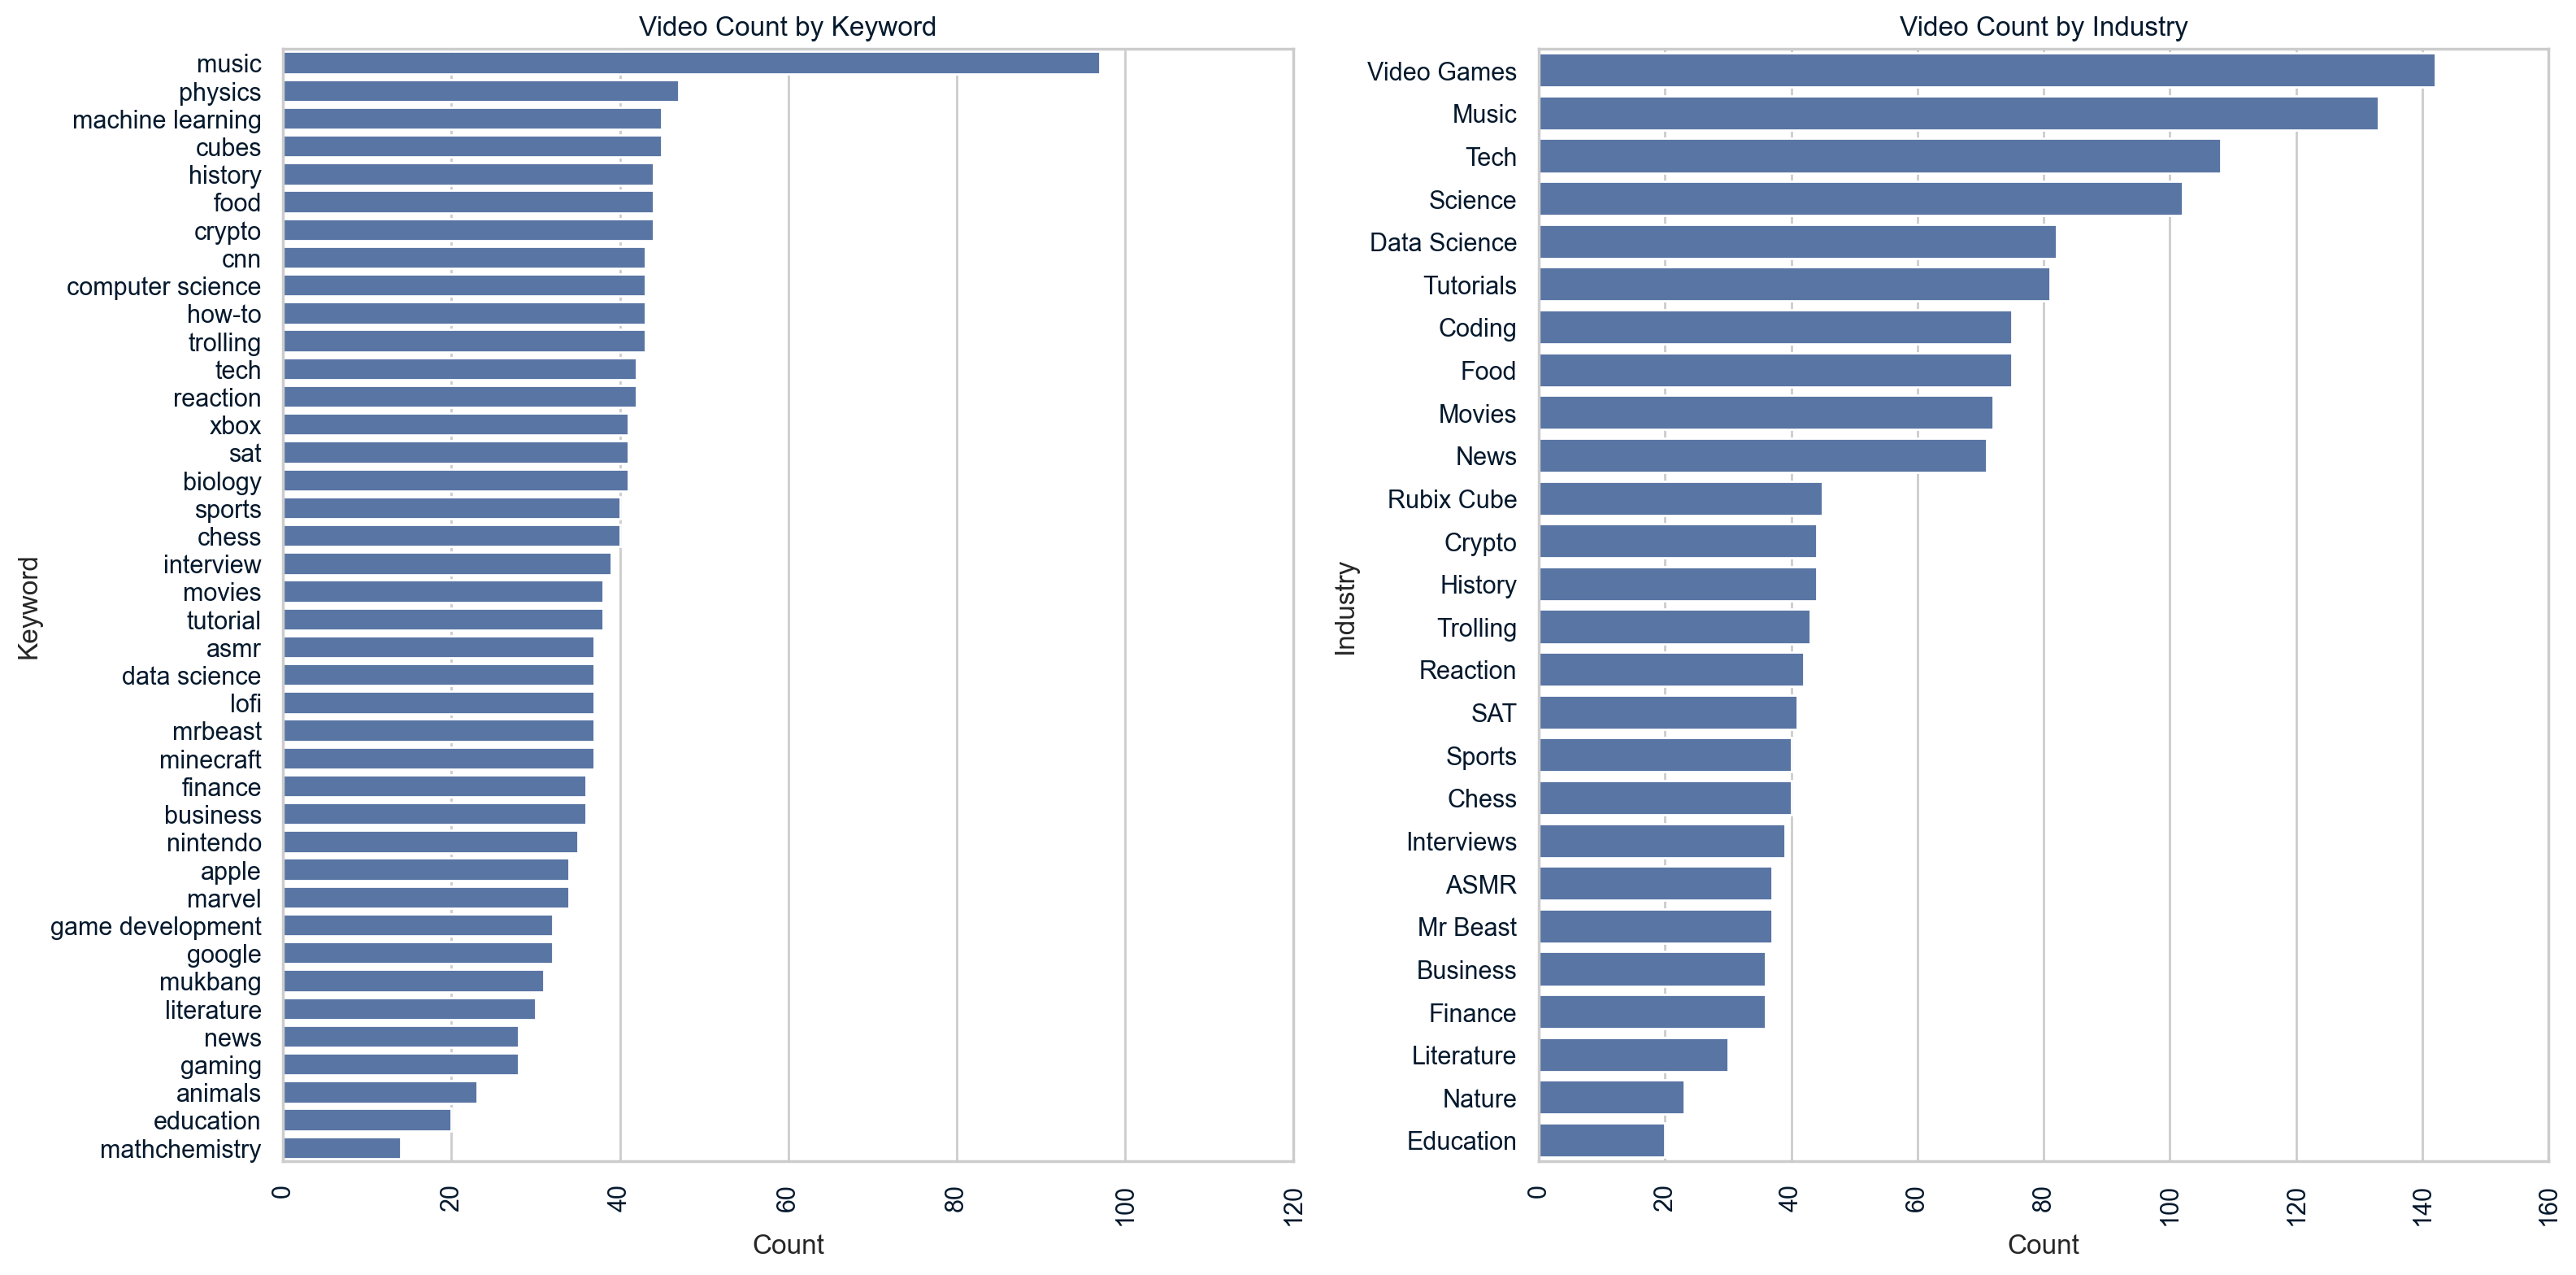

In [54]:
# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot video count by Keyword
keyword_counts = c_video_stats.groupby('Keyword')['Video ID'].count().sort_values(ascending=False).reset_index()
keyword_counts.columns = ['Keyword', 'Count']
sns.barplot(data=keyword_counts, y='Keyword', x='Count', ax=axes[0])
axes[0].set_title('Video Count by Keyword')
axes[0].set_xticks(axes[0].get_xticks())
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

# Plot video count by Industry
industry_counts = c_video_stats.groupby('Industry')['Video ID'].count().sort_values(ascending=False).reset_index()
industry_counts.columns = ['Industry', 'Count']
sns.barplot(data=industry_counts, y='Industry', x='Count', ax=axes[1])
axes[1].set_title('Video Count by Industry')
axes[1].set_xticks(axes[1].get_xticks())
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

**Insight(s)**: This graph suggests that science is the most popular industry for videos and music in the most popular keyword.

#### Comments

Preview `comments` DataFrame

In [55]:
comments.head()

,Video ID,Comment,Comment_Likes,Comment_Sentiment,Comment Clean,Comment Length,Comment Tokens
0,wAZZ-UWGVHI,Let's not forget that Apple Pay in 2014 requir...,95,1,let forget apple pay 2014 required brand new i...,325,"[let, forget, apple, pay, 2014, required, bran..."
1,wAZZ-UWGVHI,Here in NZ 50% of retailers don’t even have co...,19,0,nz 50 retailer ’ even contactless credit card ...,167,"[nz, 50, retailer, ’, even, contactless, credi..."
2,wAZZ-UWGVHI,I will forever acknowledge this channel with t...,161,2,forever acknowledge channel help lesson idea e...,187,"[forever, acknowledge, channel, help, lesson, ..."
3,wAZZ-UWGVHI,Whenever I go to a place that doesn’t take App...,8,0,whenever go place ’ take apple pay ’ happen of...,459,"[whenever, go, place, ’, take, apple, pay, ’, ..."
4,wAZZ-UWGVHI,"Apple Pay is so convenient, secure, and easy t...",34,2,apple pay convenient secure easy use used kore...,140,"[apple, pay, convenient, secure, easy, use, us..."


## V. Exploratory Data Analysis

### Statistical Summaries (Engagement Rate)

#### Engagement Rate Analysis

- Calculate the median engagement rate from the 'Engagement Rate' column

In [56]:
median_engagement_rate = c_video_stats['Engagement Rate'].median()

- Generate descriptive statistics for the 'Engagement Rate' column

In [57]:
c_video_stats['Engagement Rate'].describe()

count    1566.000000
mean        3.957388
std         3.160589
min         0.013620
25%         1.794575
50%         3.256076
75%         5.110684
max        30.812283
Name: Engagement Rate, dtype: float64

**Insight(s)**: Based on this summary, we can conclude that while the average engagement rate is relatively high ($3.974\%$), there is a significant amount of variation in engagement levels. Some content exceptionally well while others struggle to attract audience attention. 

- Create a visually informative histogram to display the frequency distribution of engagement rates

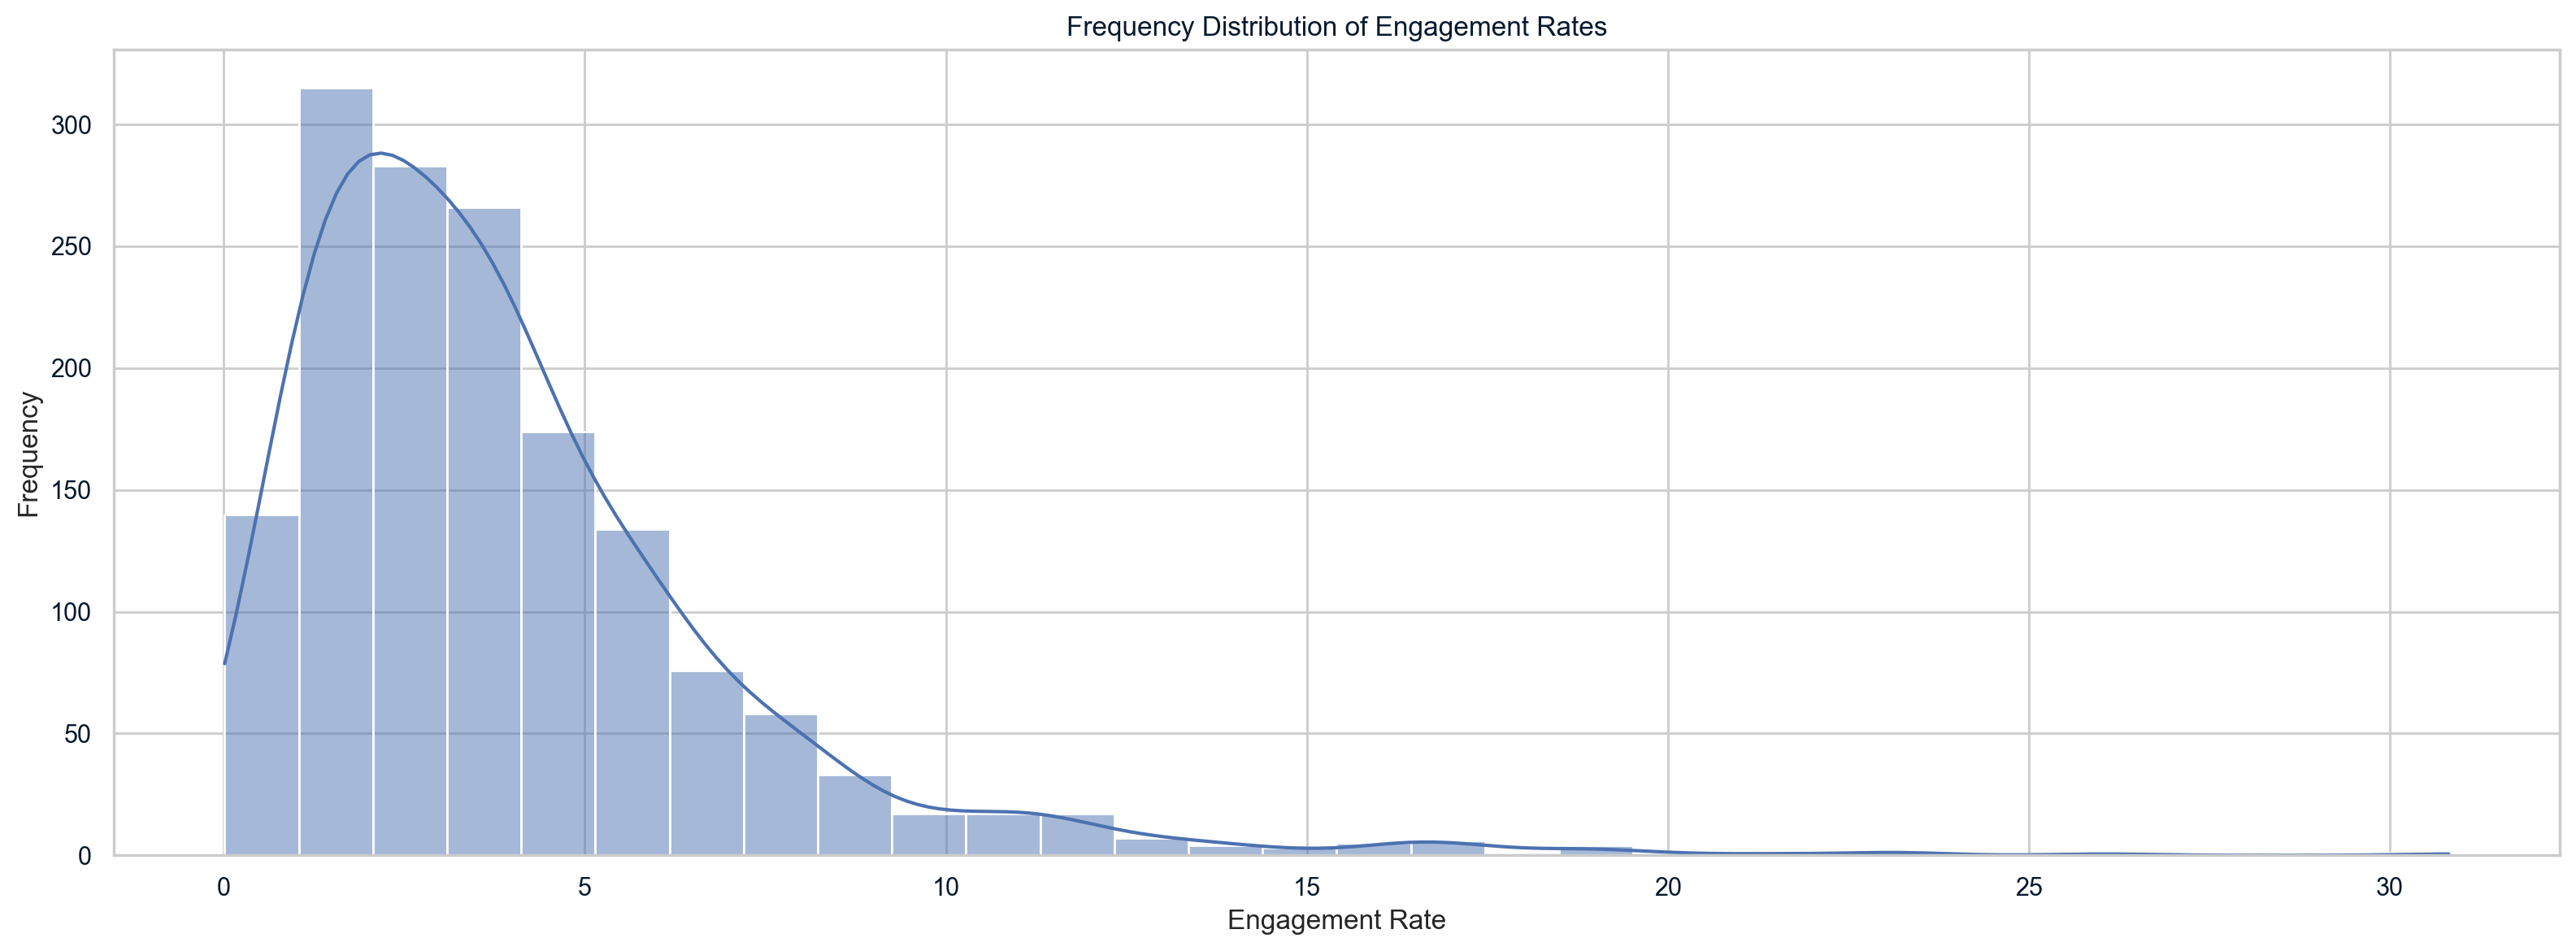

In [58]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.histplot(data=c_video_stats, x='Engagement Rate', bins=30, kde=True, ax=ax)
ax.set_title('Frequency Distribution of Engagement Rates')
ax.set_xlabel('Engagement Rate')
ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

**Insights(s)**: Based on the graph, we can see that the engagement rates for the videos are spread out across a fairly wide range. The distribution appears to be somewhat skewed to the right, with a longer tail towards higher engagement rates. This suggests that a larger proportion of the videos have engagement rates on the lower end, but there are also a few video that have achieved significantly higher engagement. 

##### by Keyword

Visualize the distribution of median engagement rates across different keywords, highlighting the dataset's median engagement rate for comparison.

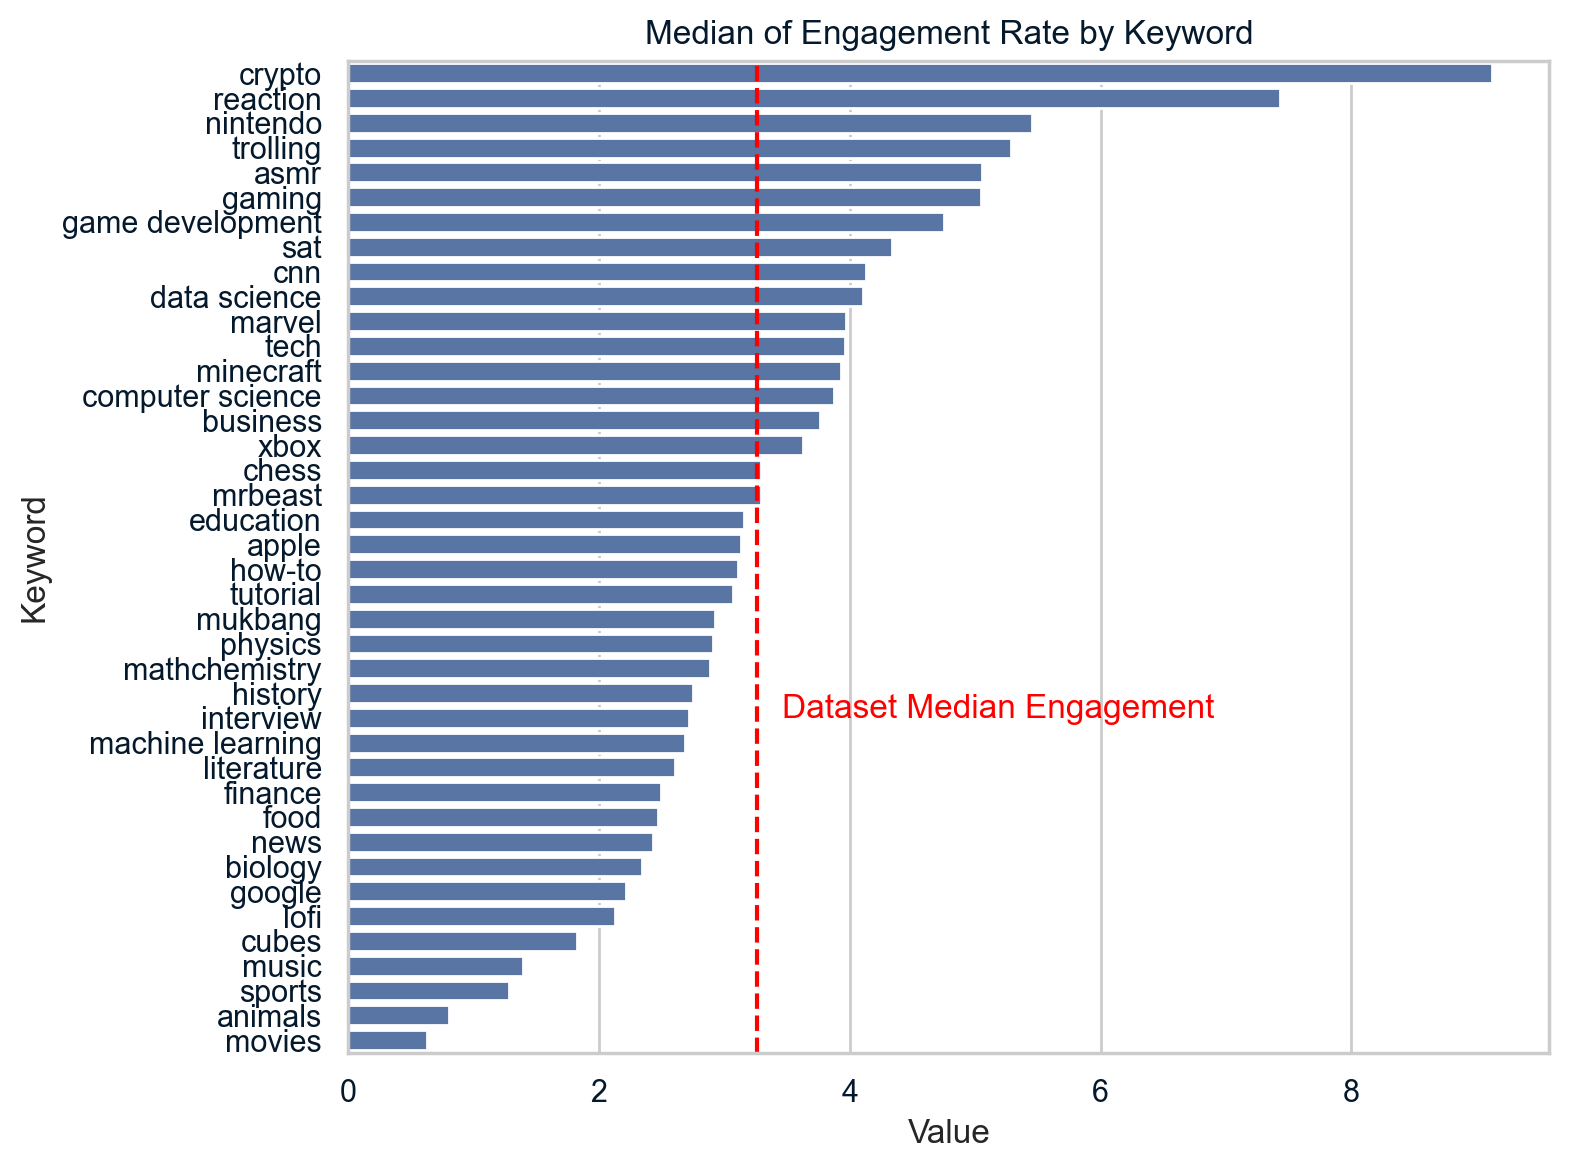

In [59]:
plt.figure(figsize=(8, 6))
plot_median_metric_by_group(c_video_stats, 'Keyword', 'Engagement Rate')

# Plot Median Engagegment Rate by Keyword
plt.axvline(median_engagement_rate, color='red', linestyle='--')
plt.text(median_engagement_rate + 0.2, 26, 'Dataset Median Engagement', color='red')
plt.title('Median of Engagement Rate by Keyword')
plt.tight_layout()
plt.show()

**Insight(s)**: Keywords like 'crypto', 'reaction', 'trolling', and 'nintendo' demonstrate notably higher median engagement rates, indicating their effectiveness in capturing audience attention and driving interaction. A group of keywords, including 'asmr', 'gaming', and 'game development', exhibit mid-range engagement rates, reflecting a moderate level of audience interest. In contrast, keywords such as 'physics', 'math', and 'chemistry' generally show lower median engagement rates, suggesting they may engage a smaller audience or resonate less strongly.

##### by Industry

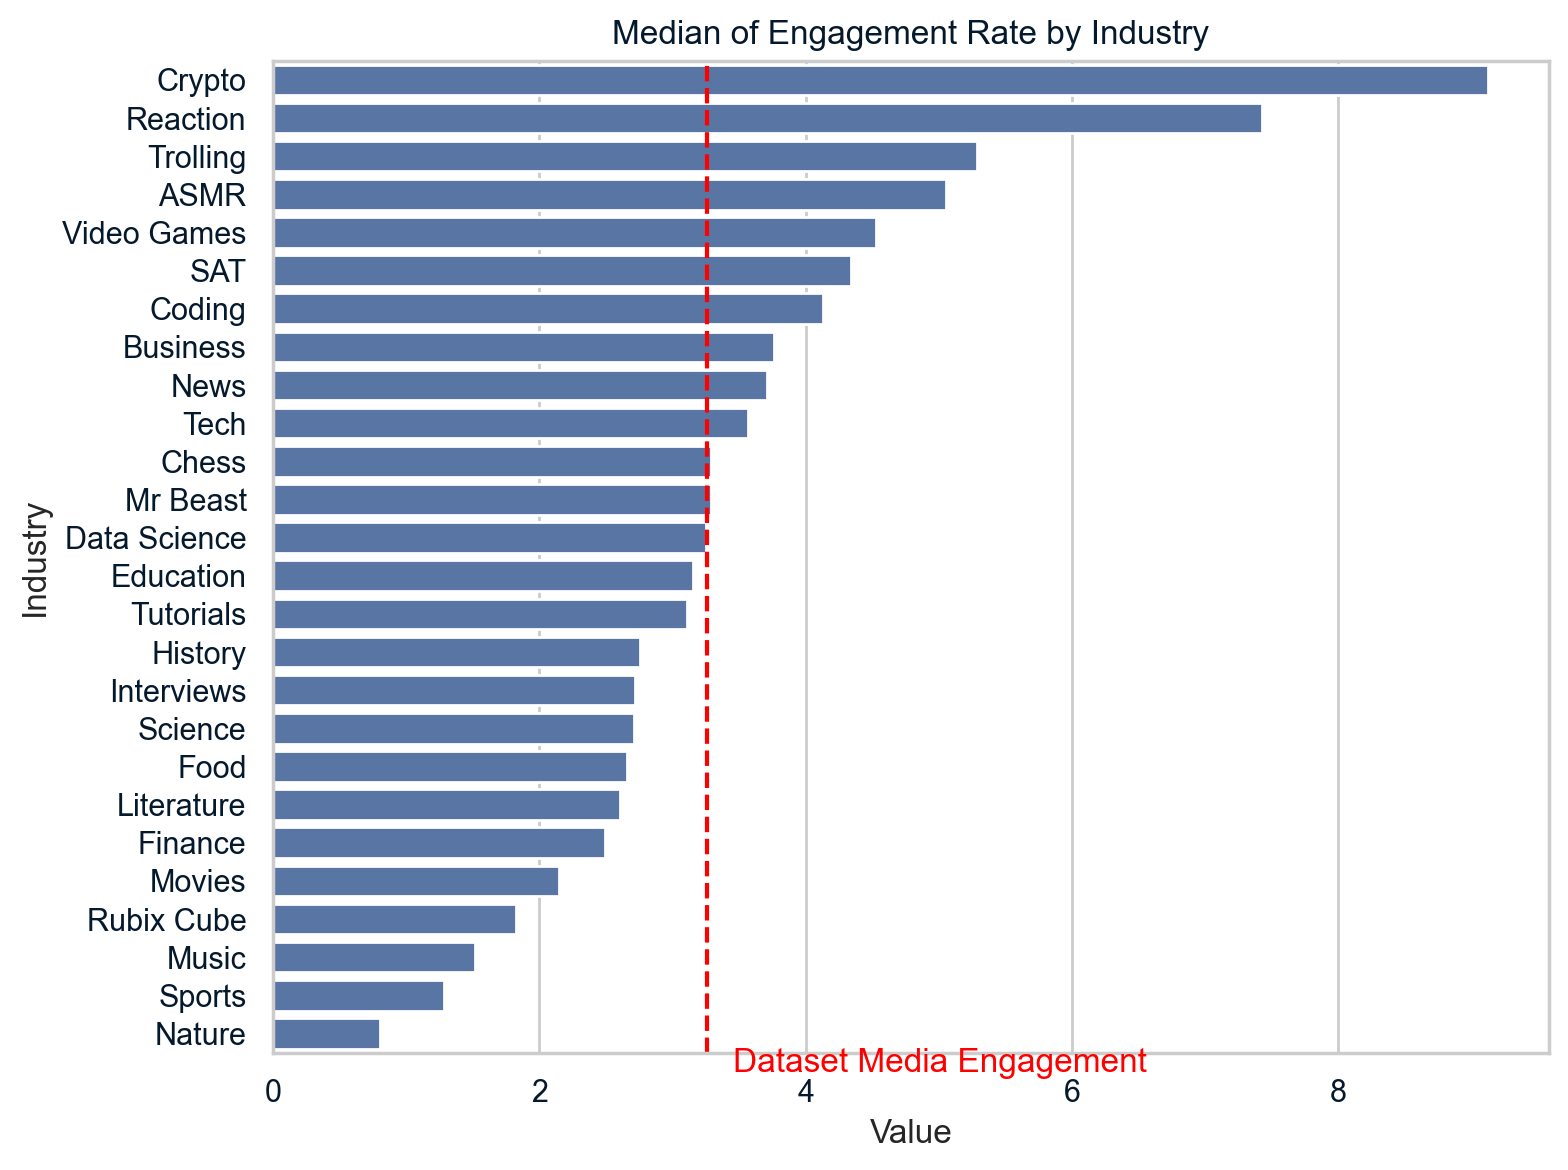

In [60]:
plt.figure(figsize=(8, 6))
plot_median_metric_by_group(c_video_stats, 'Industry', 'Engagement Rate')

# Plot Median Engagegment Rate by Industry
plt.axvline(median_engagement_rate, color='red', linestyle='--')
plt.text(median_engagement_rate + 0.2, 26, 'Dataset Media Engagement', color='red')
plt.title('Median of Engagement Rate by Industry')
plt.tight_layout()
plt.show()

**Insight(s)**: Industries such as 'Crypto', 'Reaction', and 'Trolling' exhibit significantly higher median engagement rates, indicating their strong effectiveness in capturing audience attention and driving interaction. A group of industries, including 'ASMR', 'Video Games', and 'SAT', show mid-range engagement rates, reflecting a moderate level of audience interest. In contrast, industries like 'Nature', 'Sports', and 'Music' typically display lower median engagement rates, suggesting they may engage a smaller audience or have a more niche appeal.

#### Engagement Rate Distribution

Visualizes the distribution of engagement rates across different categories.

##### by Keyword

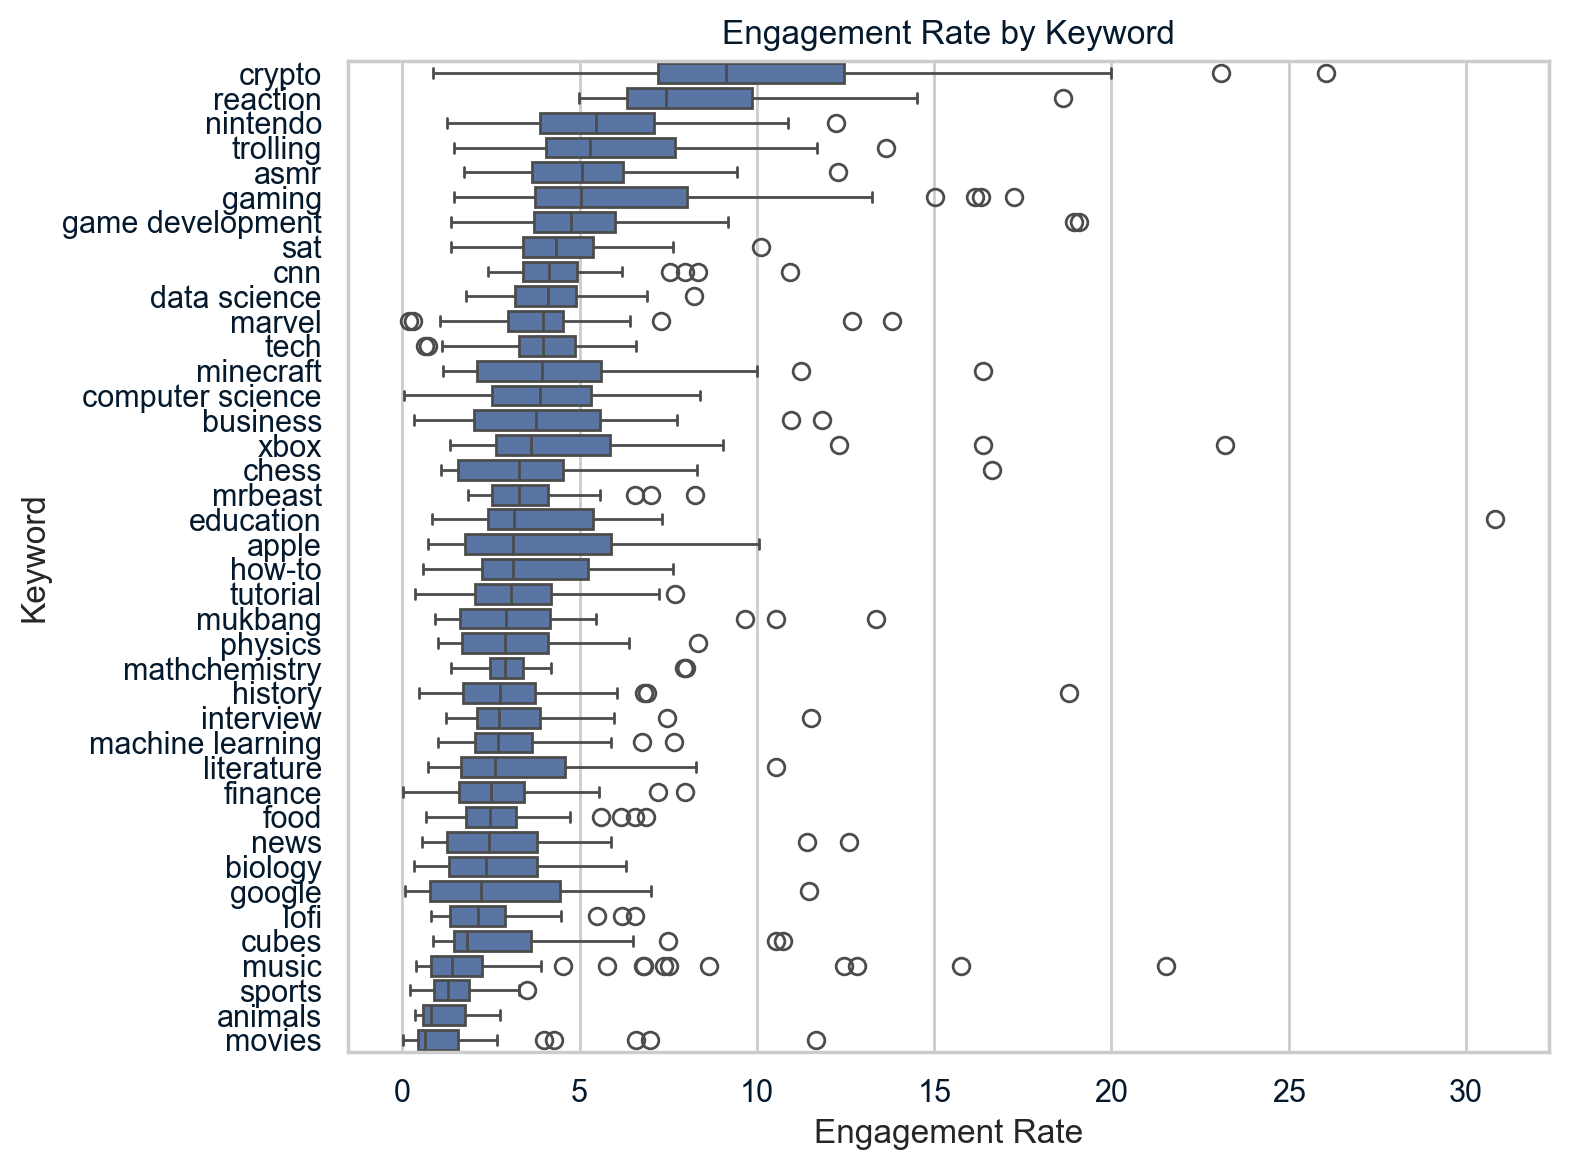

In [67]:
plt.figure(figsize=(8, 6))

# Plot the boxplot for Keyword
plot_engagement_rate_by_column(c_video_stats, 'Keyword', 'Engagement Rate')

**Insight(s)**: Based on the graph, it suggests that engagement rates for different keywords are vary significantly. This can be very valuable for content creators, marketers, and platform owners seeking to identify high-performing keywords and understand the factors that contribute to variability in audience engagement.

##### by Industry

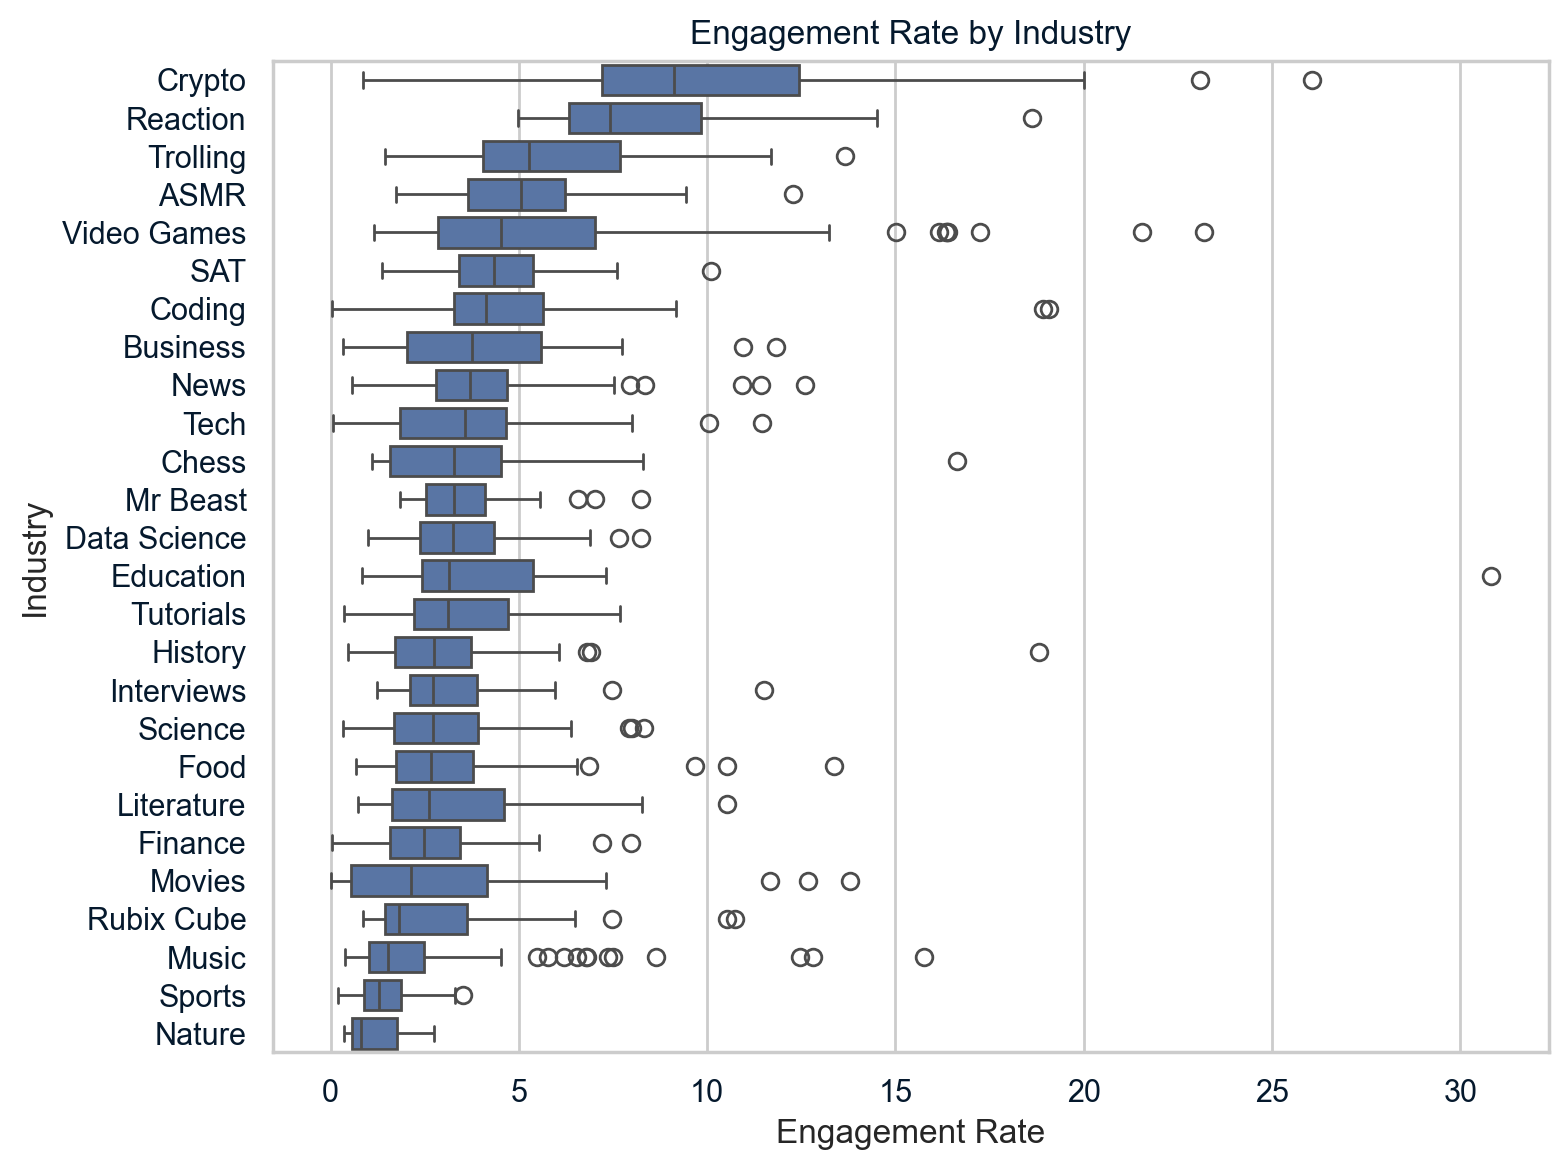

In [69]:
plt.figure(figsize=(8, 6))

# Plot the boxplot for Industry
plot_engagement_rate_by_column(c_video_stats, 'Industry', 'Engagement Rate')

**Insight(s)**: Based on the graph, it suggests that engagement rates for different industries vary significantly. This information can be valuable for content creators, marketers, and platform owners seeking to identify high-performing industries and understand the factors that contribute to variability in audience engagement.

### Statistical Summaries (Views)

Visualize the distribution of capped views across different categories.

#### View Analysis

##### by Keyword

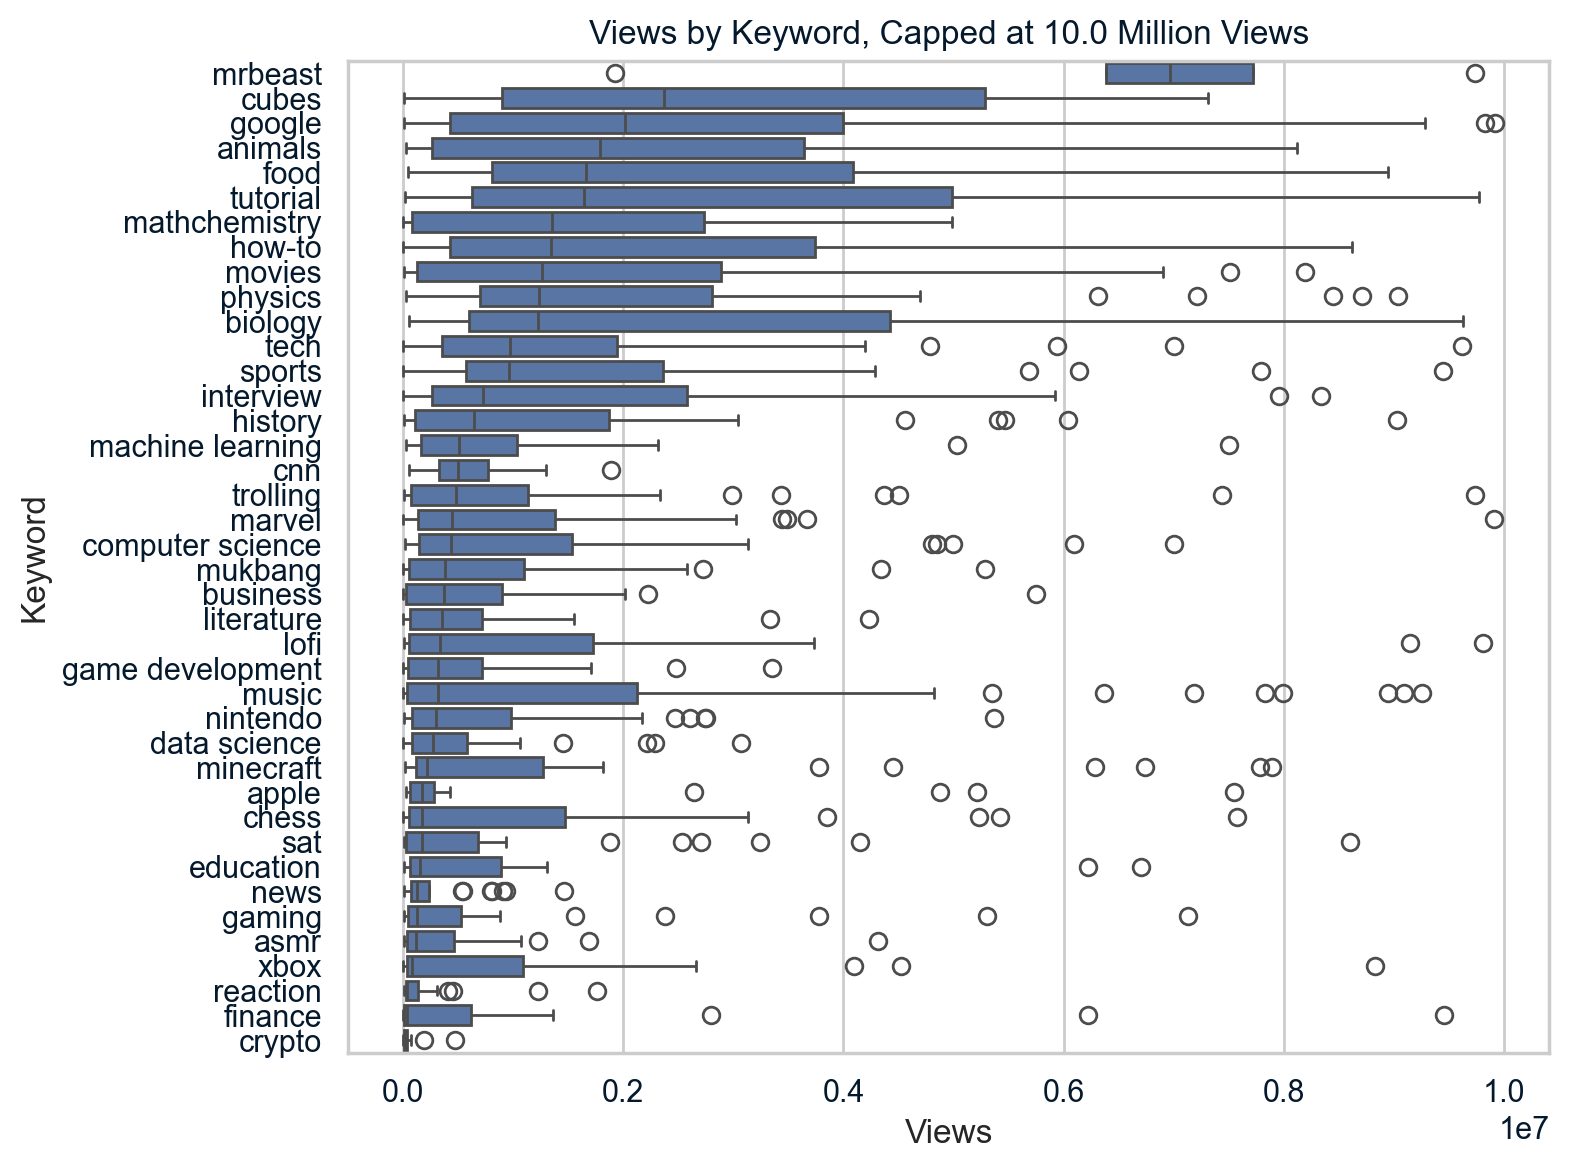

In [72]:
plt.figure(figsize=(8, 6))

# Plot the capped views boxplot for Keyword
plot_capped_views_by_column(c_video_stats, 'Keyword', 'Views', 10000000)

**Insight(s)**: The median view count for most keywords tends to be relatively low, with a significant portion of keywords falling within the 0 to 2 million view range. There is considerable variability in views across different keywords. For example, keywords like 'mrbeast' and 'cubes' display a wide range of view counts, whereas others, such as 'chess' and 'sat', show a narrower distribution. Several keywords also exhibit outliers, particularly those with higher median views, indicating the presence of a few videos with exceptionally high view counts that may skew the overall distribution. Additionally, certain keywords appear to cluster together in their view distributions. For instance, keywords related to technology and entertainment (e.g., 'tech', 'gaming', 'minecraft') generally have higher median views and greater variability.

##### by Indusrty

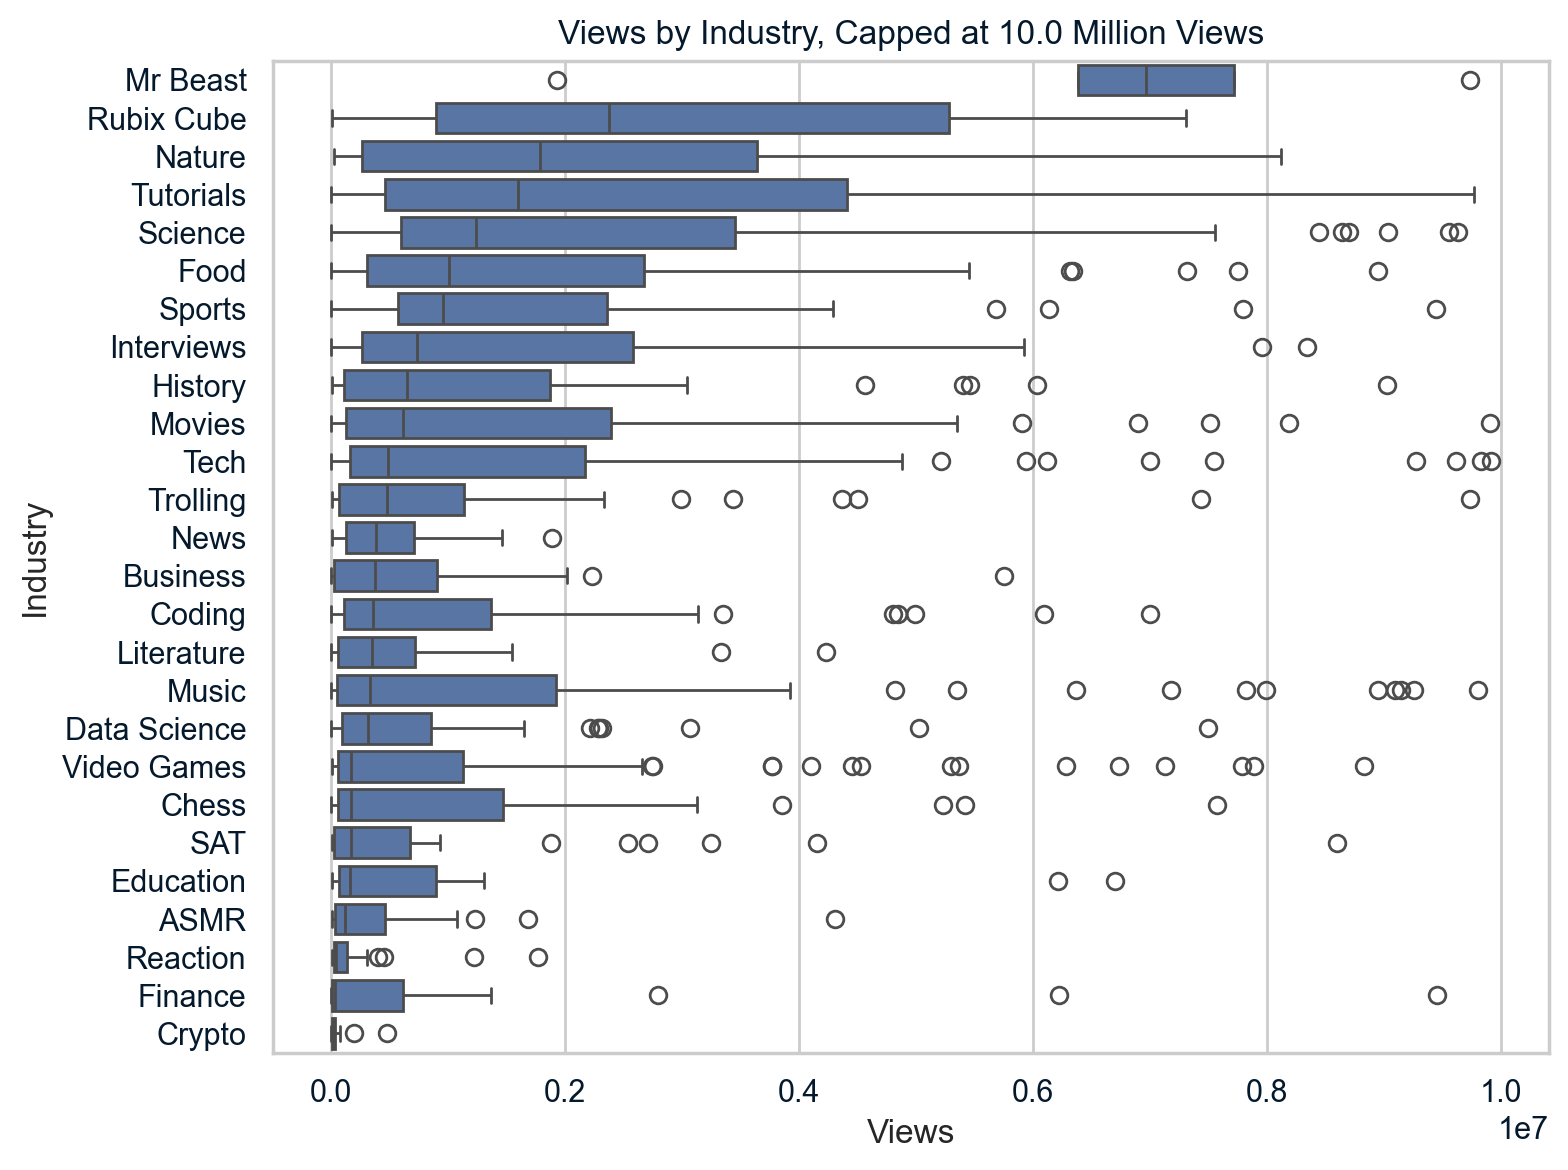

In [74]:
plt.figure(figsize=(8, 6))

# Plot the capped views boxplot for Industry
plot_capped_views_by_column(c_video_stats, 'Industry', 'Views', 10000000)

**Insight(s)**: A preliminary analysis of industry view distributions reveals a bimodal pattern. The majority of industries exhibit a relatively low median view count, primarily falling within the 0 to 2 million view range. However, a substantial degree of heterogeneity exists across industries. While some, such as 'MrBeast' and 'Rubik Cube', demonstrate a wide dispersion of views, others, like 'SAT' and 'ASMR', exhibit a more concentrated distribution. The presence of outliers, particularly in industries with higher median views, suggests that a small number of videos with exceptionally high view counts are significantly influencing the overall distribution. Moreover, a distinct clustering of industries based on view distributions is observed. Industries associated with technology and entertainment, such as 'Tech', 'Video Games', and 'Music', tend to have higher median views and a greater degree of variability.